In [1]:
import torch
import os

from tqdm import tqdm
from torchvision import models

from src.preprocessing import preprocess, relabel
from src.utils import get_transform, collate_fn, Custom_Dataset, Evaluator, Loss_Tracker, Early_Stopper
from src.plotting import show_prediction
from src.saving import Model_Manager

## The Dataset

The names of all dataset folders should be given within the `folder_names` list, all of which should be located at the `location` file directory. These should be in _COCO_ format with consistent category names.` preprocess()` will combine all datasets, outputting a single _.json_ file giving all images, category names and annotations for use within training.

Some situations may require categories to be relabelled, for instance limited visual distinction between categories may warrant combining them into one singular category to test performance. In this case, use the `relabel()` function to relabel all categories given in `target_categories` to the new label  `new_category` within the `annotations_path` _.json_ file.

In [3]:
#Give path to dataset
location = r'/path/to/datasets'
folder_names = ['Armatures', 'PCCW', 'Pure Copper']

#Preprocess
annotations_path = preprocess(location, folder_names)

#If requested, relabel categories
relabeling = False
if relabeling:
    target_categories = ['Armatures', 'Pure Copper']
    new_category = 'Copper'
    relabel(target_categories, new_category, annotations_path)

Pytorch provides two objects for storing and accessing data within training - __datasets__ and __dataloaders__. __Datasets__ store images and their corresponding labels and __Dataloaders__ wrap them into an iterable for easy access and apply any relavent data augmentation to the training set (found within `get_transform()`). Seperate dataloaders are used for seperate data subsets, each used for a different purpose during training. In this notebook, we use train and test subsets for training and evaluating the model respectively during training. A third validation subset may be added for post-training evaluation if required. `train_percent` gives the percentage of data to be used for training (train-test split). 

`batch_size` gives the number of samples to use in each iteration of model training (each time the model parameters are updated). A larger batch size tends to give quicker training times but a less accurate final model. For the purposes of this experiment, a batch size of 1 was used if training on the CPU, whilst a batch size of 4 was used if training on the GPU, but this may be changed depending on the available computational recource (ie:RAM or GPU memory size).

In [4]:
#Download dataset
train_dataset = Custom_Dataset(annotations_path, get_transform(train=True))
test_dataset = Custom_Dataset(annotations_path, get_transform(train=False))

#Split the dataset between train and test set
train_percent = .8     #Percentage of data for training
final_train_ind = int(len(train_dataset) * train_percent)
indices = torch.randperm(len(train_dataset)).tolist()        #Randomise train + test images

train_dataset = torch.utils.data.Subset(train_dataset, indices[:final_train_ind])
test_dataset = torch.utils.data.Subset(test_dataset, indices[final_train_ind:])

#Convert to dataloaders
batch_size = 1
train_data_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,shuffle=True,collate_fn=collate_fn)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

## The Model

For the purpose of this experiment, a __Faster R-CNN__ object detector was found to provide the greatest performance, but other models may be trialed to test relative perfomance on a specific task (such as those within https://pytorch.org/vision/stable/models.html). Simply assign to the `model` variable and change output dimensionality of the model head in accordance with the number of detection categories.

In [5]:
#Initialise model
model = models.detection.fasterrcnn_resnet50_fpn_v2(weights="DEFAULT")

#Modifying our classifier head for our custom number of classes
num_classes = len(train_dataset.dataset.annotations['categories'])  #Output dimension
num_input = model.roi_heads.box_predictor.cls_score.in_features     #Input dimension (unchanged)

model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(num_input, num_classes)

Check the output format of the model during training, accessed via `model.train()`, and inference, accessed via `model.eval()`. For training to function, ensure the model output is in the form of a dictionary of loss types, for instance: 

`output = {'loss_classifier': tensor(1.5008, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0370, grad_fn=<DivBackward0>)`

Predictions must be in the form of a dictionary of bounding box coordinates, labels and scores, for instance:

`predictions = {'boxes': tensor([[9.4015e+01, 3.4312e+00, 2.4989e+02, 2.6432e+02],
                [1.8404e+02, 7.7636e+00, 3.4534e+02, 2.7420e+02],
                [2.4603e+01, 2.9921e+01, 2.8768e+02, 1.8418e+02]]),
               'labels': tensor([2, 2, 2]),
               'scores': tensor([0.4148, 0.3906, 0.3779])}`

Note, the model may process multiple images at once (in batches), hence all predictions are returned in a list.

In [35]:
#Checking how our model returns data 
#For Training
model.train()  #Training mode
images, targets = next(iter(train_data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images, targets)  # Returns losses and detections
print(output)

#For Inference
model.eval()   #Evaluation mode
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)  # Returns bouding box + label predictions for each image with respective probabilities
print(predictions[0])   

/Users/benmarrett/Documents/EMR/Model Implimentation/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


{'loss_classifier': tensor(1.3194, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1261, grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.4493, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0211, grad_fn=<DivBackward0>)}
{'boxes': tensor([[9.4015e+01, 3.4312e+00, 2.4989e+02, 2.6432e+02],
        [1.8404e+02, 7.7636e+00, 3.4534e+02, 2.7420e+02],
        [2.4603e+01, 2.9921e+01, 2.8768e+02, 1.8418e+02],
        [1.1251e+02, 2.8473e+01, 3.8596e+02, 1.8915e+02],
        [4.4969e+01, 2.8730e+01, 1.9982e+02, 2.5550e+02],
        [2.2774e+01, 1.2366e+01, 5.5906e+01, 8.6970e+01],
        [6.5223e+01, 6.1727e+01, 8.8455e+01, 8.8407e+01],
        [5.6210e+01, 1.0858e+02, 3.0992e+02, 2.8447e+02],
        [1.4470e+01, 7.6641e+00, 2.9870e+01, 5.2523e+01],
        [9.1792e+01, 2.3703e+00, 1.9086e+02, 1.2926e+02],
        [2.3587e+02, 1.8383e+02, 2.7933e+02, 2.3297e+02],
        [1.3731e+02, 2.0848e+02, 3.4900e+02, 3.0000e+02],
        [2.4174e+02, 2.1458e+0

## Training

Before training, `device` will give which device to train the model on, choosing __cuda__ if available and defaulting to the __cpu__ if not. If running on __cuda__, ensure pytorch is downloaded from https://pytorch.org/get-started/locally/ with the appropriate cuda version for the PC. To running on apple silicon, manually assign `device` to __mps__ (metal performance shader) to take advantage of GPU accelerated training

The `optimizer` holds the current state of model parameters `params` and updates based on calculated gradients. Several hyperparameters may be tweaked optimise training for any specific model (note: optimal training hyperparameters for one model may not be shared with another, hence train with a range of hyperparameters and pick the best final model):

- __Learning rate__ (`lr`) - Gives the size of each optimization step (by how much model weights change for each training iteration) . This is the most important parameter which the majority of hyperparameter testing should be focused around. Default set to 0.005
- __Momentum__ (`momentum`) - Accelerates optimization through by using previous updates to model parameters in the current step of training, building up speed in the direction of the global minimum and tackling rapidly fluctuating gradients. Default set to 0.9
- __Weight Decay__ (`weight_decay`) - Prevents overfitting by adding a regularisation term to the loss, penalising excessive model complexity. Default set to 0.0005

At the start of training, a highly unoptimised model warrents larger optimization steps to , meaning training begins with a large __learning rate__. However, the later stages of optimizataion often only entail small adjustments to model parameters to fine-tune performance. It is therefore constructive to decrease the learning rate throughout training - this is the purpose of the __scheduler__ (`lr_scheduler`). Again, several hyperparameters should be tweaked to find optimum performance:

- __Step size__ (`step_size`) - The number of epochs between each adjustment of the learning rate. Default set to 3
- __Gamma factor__ (`gamma`) - Multiplicative factor by which to decay the learning rate. Default set to 0.1

In [53]:
#Train on the GPU if available, if not the CPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
print('Running using {}'.format(device))

#Initialise optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

#initialise scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

Running using cpu


Training is performed in __epochs__ (`num_epochs`), where for each epoch all training images have been used once to update model parameters. It is also standard to stop training early if model performance fails to improve to prevent overfitting and save computational resource. This is given by the `patience` parameter, giving the number of consecutive epochs over which the model's performance must fail to improve in order to stop training early. As a default, the model is trained for 50 epochs with a patience of 10, but the number of training epochs may be increased if model performance appears to still be increasing.

To save the model, give the directory `model_location` to which all models are saved. This will be combined with the model name `model_filename` to give the path to the model itself. The models are saved in version; if no `version` is given, the model will be saved as a new version within `model_path`.

Several classes assist in model training:

- `Loss_Tracker` - Tracks model loss during training and produces appropriate plots. Loss is a metric assessing model performance (eg: high loss indicates the model is perfoming badly)
- `Evaluator` - Assesses model performance at the end of every epoch using the test data contained within `test_data_loader`
- `Early_Stopper` - Compares model performance between epochs to determine whether to stop training early
- `Model_Manager` - Manages all saving tasks, keeping track of versions and saving relavent model weights and training plots

In [20]:
#Training hyperparameters
num_epochs = 50
patience = 10

#Details for saving model
model_location = r'/path/to/model'
model_filename = r'model name'
model_path = os.path.join(model_location, model_filename)
version=None

#Objects to assist in training 
loss_tracker = Loss_Tracker()
evaluator = Evaluator(test_data_loader)
early_stopper = Early_Stopper(patience)
model_manager = Model_Manager(model_path)

/Users/benmarrett/Documents/EMR/Model Implimentation/.venv/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


For each epoch, all training data is looped through before the model is evaluated. We use COCO evaluator, which assess the model within a range of different scenarios. However for our purposes, the most important evaluation metric is the mean average precision with an IOU threshold of .5 (mAP50), which is the second metric printed at for evaluation:

    `Average Precision (AP) @[ IOU=0.50     | area=   all | maxDets=100 ] = ...`

This metric is used by the `early_stopper` to assess model performance and is tracked by the `evaluator` to plot model performance over time. Evaluation metrics are explored in more detail in the accompanying document.

At the end of each each epoch, if model performance improves then the `model_manager` performs a backup, meaning only the model weights are saved. If training is not interupted, at the end of training any backups are removed. At the end of training, `model_manager` performs a detailed save. This includes saving relavent evaluation plots (loss plots, mAP50 plots and confusion matrix) but also information regarding the data subsets used for training, testing, etc... are saved as _.json_ files. These files log which images and their respective annotations were used for training and testing, meaning the same model can be evaluated on the same test data or trained on the same training data if any further tweaks are made.

In [43]:
n_print = 1    #Number of SGD iterations after which to update loss in progress_bar
stop = False   #Determines whether to early stop

for epoch in range(num_epochs):
    model.train()

    print(f"-------------------------------\nEpoch {epoch + 1}\n-------------------------------")

    progress_bar = tqdm(train_data_loader, desc="Training", unit="batch")

    #Loop through training data in batches
    for images, targets in progress_bar:
        #Send data to appropriate device
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)   ##Return the loss
        loss_tracker.update(loss_dict)
        
        optimizer.zero_grad()
        losses = sum(loss for loss in loss_dict.values())
        losses.backward()
        optimizer.step()

        #Print loss occationally
        if loss_tracker.iteration % n_print == 0:
            progress_bar.set_postfix(loss=f"{loss_tracker.loss}")
    
    #Update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()

    print(f"Epoch final loss: {loss_tracker.loss}")

    #Evaluate on the test dataset
    evaluator.evaluate(model, device=device)
    loss_tracker.mark_epoch()

    #Detect if early stop and save if true
    stop = early_stopper.early_stop(evaluator.mAP50)
    if stop:   
        print('Stopped early on epoch {} as mAP50 failed to improve for {} epochs'.format(epoch+1, patience))
        model_manager.save(model_filename, version=version, data_loaders=[train_data_loader, test_data_loader], data_loader_names=['train', 'test'], loss_tracker=loss_tracker, evaluator=evaluator)
        break

    #Quick save backup if model improved performance
    elif early_stopper.improved == True:
        print(f'Precision Improved to {evaluator.mAP50}')
        model_manager.backup(model, version=version)

#If didnt early stop, save final model
if not stop:
    #Load best model from backups
    model = model_manager.load(version=version, weights_only=False)
    #Detailed save if reached end of training
    model_manager.save(model_filename, version=version, data_loaders=[train_data_loader, test_data_loader], data_loader_names=['train', 'test'], loss_tracker=loss_tracker, evaluator=evaluator)

-------------------------------
Epoch 1
-------------------------------


Training:   1%|          | 4/368 [00:14<22:17,  3.67s/batch]


KeyboardInterrupt: 

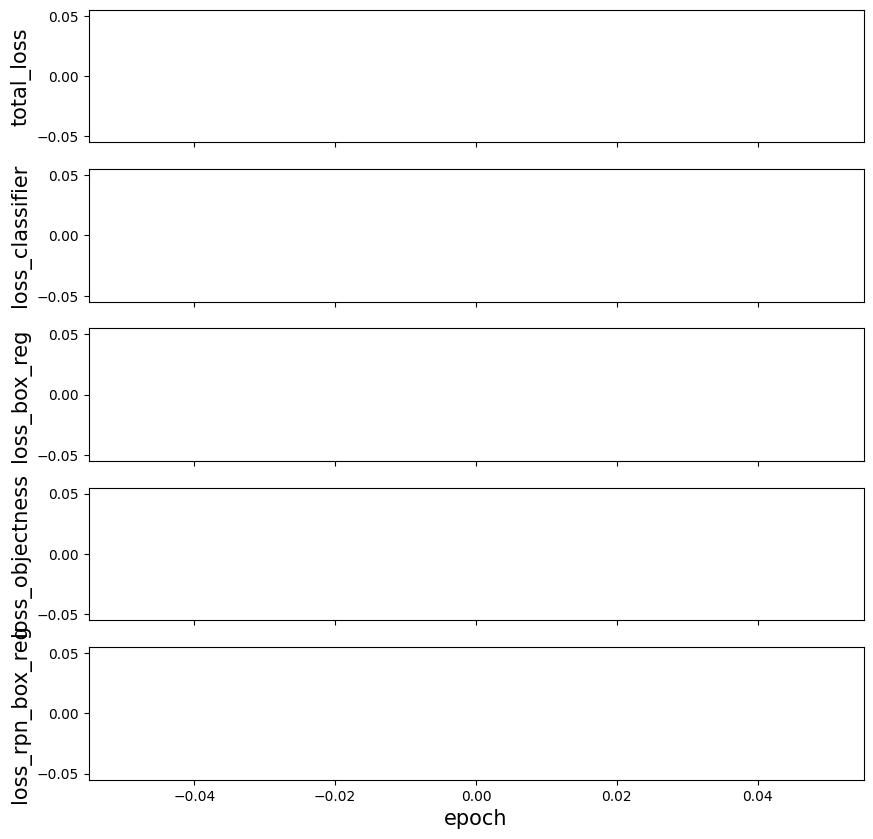

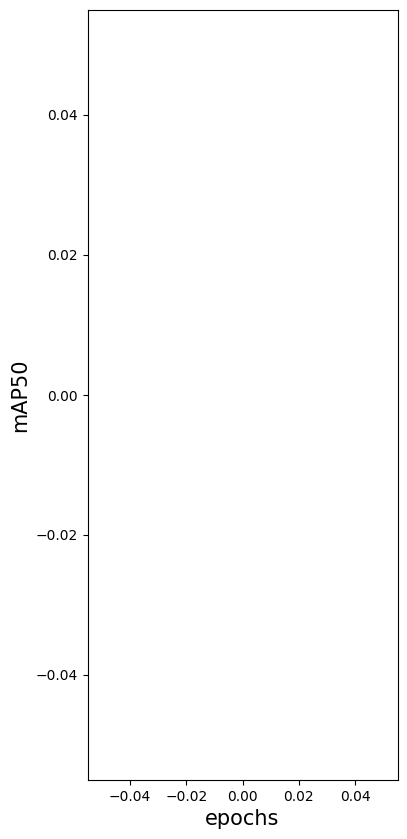

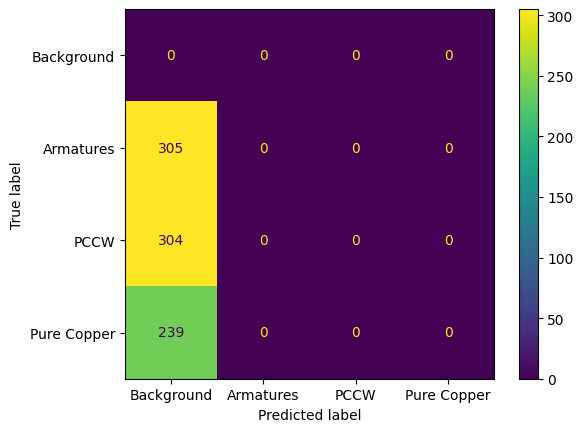

(None, None, None)

In [32]:
#Evaluation plots
loss_tracker.plot(keys=['total_loss'] + list(loss_tracker.loss_types))
evaluator.plot()
evaluator.confusion_matrix()

## Inference

The `show_prediction()` function allows you to test model inference on a given image. The user may either give a `path` to the image file or a dataloader from which a random image is selected for inference. To save the inference plot, give the desired saving location at `filename` and assign to `image_filename` variable within `show_prediction()`

Speed : 1536.7ms inference, 0.0ms plotting


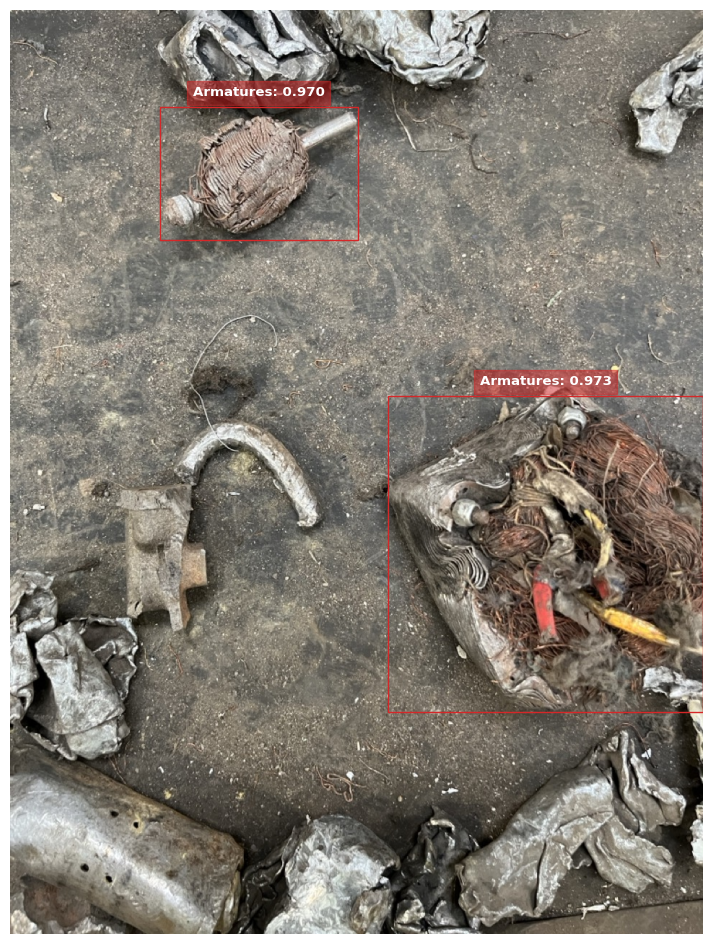

In [81]:
#Path to image for inference
input_image_location = '/path/to/image/file'
directory = sorted(os.listdir(input_image_location))    #Sort directory by filename
input_image_name = directory[45]                        #Choose image for inference
input_path = os.path.join(input_image_location, input_image_name)

#Location to save image
saving_location = '/path/to/save/image'
image_filename = 'image filename'
filename = os.path.join(saving_location, image_filename)

#Categories used to label bounding boxes
categories = {category['id'] : category['name'] for category in test_dataset.dataset.annotations['categories']}

#Perform inference
show_prediction(model, categories, data_loader=test_data_loader, score_filter = .5, figsize=(12,12))
#show_prediction(model, categories, path=input_path, score_filter = .5, figsize=(12,12))

## Saving and Loading

As described above, to save a model, simply give the path to the folder at which all models are saved and then the model name. If no `version` is given, the model will be saved as the latest version. If the user wishes to log which data was used for training/testing, input the subset dataloaders within the list `data_loaders` and their corresponding names within `data_loader_names`.

In [5]:
#Give path to model
file_location = '/path/to/model'
model_filename = 'model name'
path = os.path.join(file_location, model_filename)

#Save model
model_manager = Model_Manager(path)
model_manager.save(model, version=None, data_loaders=[train_data_loader, test_data_loader], data_loader_names=['train', 'test'])

NameError: name 'model2' is not defined

Loading a model is performed similarly, by giving the path to and name of a given model. Again, if a specific `version` is not given, the latest version is loaded. Setting `give_annotations` to `True` additionaly outputs the paths to _.json_ annotations files, giving data subsets used for training/testing.

In [86]:
#Give path to model
file_location = '/path/to/model'
model_filename = 'model name'
path = os.path.join(file_location, model_filename)

#Save model
model_manager = Model_Manager(path)
model = model_manager.load(version=None, give_annotations=False)

Model loaded from /Users/benmarrett/Documents/EMR/Model Implimentation/Saved Models/Faster RCNN All Classes/v_2
